In [5]:
import nltk
from nltk.corpus import stopwords
import json
import tweepy
from collections import defaultdict
import time
import pandas as pd
from nltk.tokenize import TweetTokenizer
import random

In [2]:
#uncomment and run this cell
#! python -mpip install gensim python-Levenshtein

  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp38-cp38-win_amd64.whl size=83351 sha256=71e208ac26f3faaea3cb4b9008ee7051bf74bc497ae064fc0f3d8e96e51d4f3e
  Stored in directory: c:\users\tndud\appdata\local\pip\cache\wheels\d7\0c\76\042b46eb0df65c3ccd0338f791210c55ab79d209bcc269e2c7
Successfully built python-Levenshtein
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [8]:
bearer = "AAAAAAAAAAAAAAAAAAAAAC%2FJZwEAAAAAMbrOfWhkbRcB9p0CRF3BPBx11U8%3DZuiKEqoQb2JyxBm6GhCWPZ6eipuYaMIcFlrypU6CTuyjiMy6WN"


In [191]:
client = tweepy.Client(bearer_token=bearer, wait_on_rate_limit=True)


def get_tweets(client, input_query, n=3000):
    page_size = 100
    pages = n // 100 + 1
    i = 0
    for tweet_batch in tweepy.Paginator(client.search_recent_tweets, input_query,
                                  tweet_fields=["created_at", "public_metrics", "entities"],
                                   expansions=["author_id"],
                                  user_fields=["username", "public_metrics"],
                                  max_results=page_size, limit=pages):
        user_lookup = {u.id: u.data for u in tweet_batch.includes["users"]}
        for tweet in tweet_batch.data:
            data = tweet.data
            data["author"] = user_lookup[tweet.author_id]
            i += 1
            yield tweet
            
            if i == n:
                return
            
def get_entities(tweet, entity):
    if tweet.entities and entity in tweet.entities:
        return tweet.entities[entity]
    else:
        return []

# Collecting Tweets

Please note that we use three different topics in this case just for clarity. 

In [192]:
input_queries = ["covid"]

dataset = []
download_tweet_count = 3000
seen = {}
for input_query in input_queries:
    #Download, skipping retweets, look for english
    input_query_nort = "{} -is:retweet lang:en".format(input_query)
    print(input_query)
    q_dataset = []
    for i, tweet in enumerate(get_tweets(client, input_query_nort)):
        datum = {
            "topic": input_query,
            "id": tweet.id,

            #user related info
            "username": tweet.author["username"],
            "name": tweet.author["name"],
            "user_followers_count": tweet.author["public_metrics"]["followers_count"],
            "user_friends_count": tweet.author["public_metrics"]["following_count"],
            # tweet related information
            "text": tweet.text,
            "created_at": tweet.created_at.strftime("%Y-%m-%d %H:%M:%S"),
            "like_count": tweet.public_metrics["like_count"],
            "retweet_count": tweet.public_metrics["retweet_count"],
            # some extracted data from tweet
            "hashtags": ','.join(ht['tag'] for ht in get_entities(tweet, "hashtags")),
            "mentioned_urls": ','.join(url['expanded_url'] for url in get_entities(tweet, 'urls')),
            "mentioned_user_ids": ','.join(mention['id'] for mention in get_entities(tweet, "mentions")),
            "mentioned_user_names": ','.join(mention['username'] for mention in get_entities(tweet, "mentions")),
        }
        q_dataset += [datum]

        if (i + 1) % 100 == 0:
            print("processed {} tweets: saved {}".format(i + 1, len(q_dataset)))
                  
        if len(q_dataset) >= download_tweet_count:
            break
    dataset += q_dataset

covid
processed 100 tweets: saved 100
processed 200 tweets: saved 200
processed 300 tweets: saved 300
processed 400 tweets: saved 400
processed 500 tweets: saved 500
processed 600 tweets: saved 600
processed 700 tweets: saved 700
processed 800 tweets: saved 800
processed 900 tweets: saved 900
processed 1000 tweets: saved 1000
processed 1100 tweets: saved 1100
processed 1200 tweets: saved 1200
processed 1300 tweets: saved 1300
processed 1400 tweets: saved 1400
processed 1500 tweets: saved 1500
processed 1600 tweets: saved 1600
processed 1700 tweets: saved 1700
processed 1800 tweets: saved 1800
processed 1900 tweets: saved 1900
processed 2000 tweets: saved 2000
processed 2100 tweets: saved 2100
processed 2200 tweets: saved 2200
processed 2300 tweets: saved 2300
processed 2400 tweets: saved 2400
processed 2500 tweets: saved 2500
processed 2600 tweets: saved 2600
processed 2700 tweets: saved 2700
processed 2800 tweets: saved 2800
processed 2900 tweets: saved 2900
processed 3000 tweets: sav

In [91]:
#dataset2 = [t for t in dataset if "harvard" in t["text"].lower()] + [t for t in dataset if "stanford" in t["text"].lower()] + [t for t in dataset if "virginia" in t["text"].lower()]
#random.shuffle(dataset2)

In [355]:
dt = pd.DataFrame.from_dict(dataset)
dt[['created_at','text','hashtags','username','user_followers_count','topic']].sample(10)

,created_at,text,hashtags,username,user_followers_count,topic
2249,2022-04-20 17:27:47,@sesmith Pull mask down and speak directly int...,,mattmaison,538,covid
2128,2022-04-20 17:28:33,@Tomisback10 @OKSt8Fan @DLoesch The hospitaliz...,,TypeACommentary,54,covid
174,2022-04-20 17:40:45,"This afternoon, @MarisaJacquesTV is going long...",Ukraine,RobGuaderrama,3363,covid
1302,2022-04-20 17:33:42,"🤣Some girl said she has covid, so they gave he...",,Tee_NN,522,covid
703,2022-04-20 17:37:30,Why did you with hold your blood lust?You sho...,,ManojeNath,571,covid
2215,2022-04-20 17:28:00,"Meet @emmabgo, a reporter @nytimes. Emma has b...",FoW,UCB_COEH,257,covid
750,2022-04-20 17:37:12,"@toomuchbass @mattyglesias really, where's the...",,DL_138,192,covid
1148,2022-04-20 17:34:41,Cuts was a dub in 2019 soon as Covid hit the ...,,FuckCloutHTP,368,covid
2110,2022-04-20 17:28:41,Everybody in NYC who doesn’t have COVID got a ...,,keyleemiracle,2156,covid
824,2022-04-20 17:36:43,"""The average price of wraps last month was up ...",,mikesisak,8751,covid


In [264]:
dt["text"][1]

'all my homies hate state/legal definitions of disability bc if covid has shown us anything it’s that theyre useless and effectively only function to keep other disabled ppl from accessing certain (still inadequate) measures'

In [94]:
all_docs = dt['text'].values
print(all_docs[0])

economic relief (for covid, basic healthcare &amp; more) instantly became a non-issue for Democrats once Trump was out of office. but guess what, it's not a non-issue for people who still need that relief &amp; expected the more "compassionate" party to give it to them for their votes 🙃


# Word Tokenization using TweetTokenizer
This tokenizer is customized for tokenizing tweet data. Try using a different tokenizer to see how the result of your LDA will change.

In [265]:
import string
exclude = set(string.punctuation)
tokenized = []
tokenizer = TweetTokenizer()
for doc in all_docs:
    tokens = tokenizer.tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())
print(tokenized[1])

['rayaboody', 'blackknight10k', 'that', '’', 's', 'what', 'i', '’', 've', 'said', 'between', 'covid', 'and', 'ball', 'baking', 'we', 'could', 'solve', 'the', 'maga', 'problem']


# Stop word removal
Certain parts of English speech, like conjunctions ("in", "for") are meaningless to a topic model. These terms are called stop words and need to be removed from our token list.
Customize additional stopwords

In [353]:
sws = set(stopwords.words('english'))
sws.add('rt') # Tweet specific stop-words
sws.add("…") 



In [169]:
#!pip install wordcloud

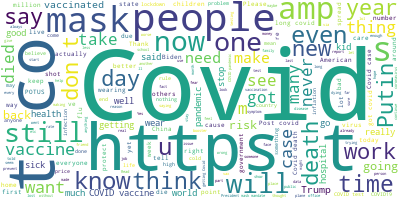

In [196]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(dt['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [354]:
swl = ['covid19','get','one', 'like', 'still', 'thats', 'see', 'long', 'people', 'would', 'know', 'think', 'also', 'many', 'say','first','two', 'dont','going','work', 'want','need','got', 'due', 'never', 'really', 'cases', 'back', 'since', 'even', 'though', 'tell', 'without', 'pandemic', 'well','week', 'via', 'number','take', 'need', 'make', 'much', 'said', 'year', 'thing' , 'getting', 'day', 'covid-19', 'bad', 'good', 'leave', 'catch', 'impact','look', 'million', 'spread', 'health' , 'news', 'wear', 'state', 'could', 'per', 'years', 'time', 'great', 'read', 'case', 'sure', 'right', 'come', 'death', 'stop','prevent', 'care', 'sick', 'die', 'post', 'risk', 'feel', 'cause', 'order', 'lose','child', 'happen', 'life', 'kill']
for a in swl:
    sws.add(a)

Reference for making word clouds:https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [184]:
#!pip install spacy

In [186]:
#!python -m spacy download en

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## lemmatization

Reference: https://spacy.io/usage

In [356]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

def lematized_doc(text): 
    rev_text = nlp(text)
    rev_text = ([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in sws and not token.is_punct and len(token.text) > 3])
    return rev_text

In [261]:
dt.text

0       [@angryhacademic, @dbkell, covid, clinic, say,...
1       [homie, hate, legal, definition, disability, c...
2       [decide, celebrate, covid, smash, cadbury, ora...
3       [reaction, mask, mandate, airline, lift, skept...
4                   [@bejirm, carlo, post, covid, parlon]
                              ...                        
2995    [@paulchenkaiser, @nationalpost, thank, info, ...
2996        [covid, plane, disgusting, mask, lysol, wipe]
2997    [webinar, watch, covid-19, change, care, home,...
2998    [effect, covid, true, tenor, lose, octave, ran...
2999    [@colleenb123, ticket, covid, waukegan, wife, ...
Name: text, Length: 3000, dtype: object

In [357]:
lematized = dt['text'].apply(lematized_doc)

Stopword removal for each topic

In [358]:
sws_removed=[]
for j,sent in enumerate(lematized):
    sws_removed.append([i for i in sent if i not in sws and len(i) > 2])
print(sws_removed[1])

['homie', 'hate', 'legal', 'definition', 'disability', 'covid', 'show', 'useless', 'effectively', 'function', 'disabled', 'access', 'certain', 'inadequate', 'measure']


In [133]:
#!pip install vaderSentiment

# Gensim Library
The result of our cleaning stage is tweets, a tokenized, stop-removed list of words from a single tweet. We looped through all our documents and appended each one to our sws_removed variable. So now sws_removed is a list of lists, one list for each of our original tweets.

To generate an LDA model, we need to understand how frequently each term occurs within each document. To do that, we need to construct a document-term matrix with a package called gensim:

In [359]:
from gensim import corpora, models
dictionary = corpora.Dictionary(sws_removed)
dictionary.filter_extremes(no_below=5, no_above=0.3)
dictionary.compactify()

The Dictionary() function traverses data, assigning a unique integer id to each unique token while also collecting word counts and relevant statistics. To see each token's unique integer id, try print(dictionary.token2id).

Next, our dictionary must be converted into a bag-of-words:

In [360]:
corpus = [dictionary.doc2bow(text) for text in sws_removed]

The doc2bow() function converts dictionary into a bag-of-words. The result, corpus, is a list of vectors equal to the number of tweets. In each tweet vector is a series of tuples. As an example, print(corpus[2]) results in the following:

In [361]:
print(corpus[1])

[(3, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


This list of tuples represents our first tweet. The tuples are (term ID, term frequency) pairs. doc2bow() only includes terms that actually occur: terms that do not occur in a tweet will not appear in that tweet's vector.

# LDA model
corpus is a document-term matrix and now we are ready to generate an LDA model:

In [362]:
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=20)

The LdaModel class is described in detail in the gensim documentation.
Parameters used in our example:
num_topics: required. An LDA model requires the user to determine how many topics should be generated. Our document set is small, so we’re only asking for three topics.
id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
passes: optional. The number of laps the model will take through corpus. The greater the number of passes, the more accurate the model will be. A lot of passes can be slow on a very large corpus.

# Examining the results
Our LDA model is now stored as ldamodel. We can review our topics with the print_topic and print_topics methods:

In [363]:
ldamodel.print_topics(num_topics=4, num_words=10)

[(0,
  '0.041*"mask" + 0.018*"test" + 0.017*"mandate" + 0.014*"vaccine" + 0.009*"live" + 0.008*"school" + 0.007*"understand" + 0.007*"april" + 0.007*"hard" + 0.007*"nearly"'),
 (1,
  '0.021*"high" + 0.020*"putin" + 0.018*"biden" + 0.012*"mask" + 0.012*"price" + 0.012*"blame" + 0.011*"president" + 0.010*"trump" + 0.009*"china" + 0.009*"inflation"'),
 (2,
  '0.017*"hospital" + 0.012*"vaccine" + 0.009*"break" + 0.009*"show" + 0.008*"datum" + 0.007*"hope" + 0.007*"2022" + 0.006*"increase" + 0.006*"different" + 0.006*"kid"'),
 (3,
  '0.031*"mask" + 0.019*"vaccine" + 0.010*"update" + 0.009*"cold" + 0.009*"virus" + 0.008*"vaccinate" + 0.008*"plane" + 0.007*"effect" + 0.007*"protect" + 0.007*"booster"')]

In [274]:
print(len(corpus))

3000


In [259]:
print(len(dt['text']))

3000


What does this mean? Each generated topic is separated by a comma. Within each topic are the three most probable words to appear in that topic. Even though our document set is small the model is reasonable.

In [298]:
topics_df = pd.DataFrame()
for i in range(0, len(corpus)):  
    topics = ldamodel.get_document_topics(corpus[i])
    topics = sorted(topics, key=lambda x: -x[1])
    for j, (topic_num, prop_topic) in enumerate(topics):
            
            # Diplay the dominant topics
            if j == 0:  
                dom = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in dom])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,2)*100, topic_keywords]), ignore_index=True)
            else:
                break

In [299]:
topics_df

,0,1,2
0,2.0,41.000000,"putin, death, high, blame, biden, president, l..."
1,0.0,44.000000,"mask, vaccine, test, home, sure, right, sick, ..."
2,0.0,52.999997,"mask, vaccine, test, home, sure, right, sick, ..."
3,1.0,94.000000,"mask, start, mandate, stop, school, prevent, c..."
4,3.0,75.000000,"die, death, vaccine, post, world, trump, china..."
...,...,...,...
2995,3.0,47.999999,"die, death, vaccine, post, world, trump, china..."
2996,1.0,75.000000,"mask, start, mandate, stop, school, prevent, c..."
2997,0.0,57.999998,"mask, vaccine, test, home, sure, right, sick, ..."
2998,2.0,83.999997,"putin, death, high, blame, biden, president, l..."


In [280]:
original = dt['text']

## Sentiment Analysis

In [300]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


rows =[]

analyzer = SentimentIntensityAnalyzer()

compound=[]
for sentence in original:
    #joined = " ".join(sentence)
    vs = analyzer.polarity_scores(sentence)
    compound.append(vs['compound'])

    


In [301]:
hashtag = pd.Series(dt['hashtags'])
sent = pd.Series(compound)
original_txt = pd.Series(original)
topics_df = pd.concat([topics_df,original, hashtag, sent], axis=1)


In [302]:
topics_df

,0,1,2,text,hashtags,0
0,2.0,41.000000,"putin, death, high, blame, biden, president, l...",@angryhacademic @dbkell The long covid clinic ...,,0.2609
1,0.0,44.000000,"mask, vaccine, test, home, sure, right, sick, ...",all my homies hate state/legal definitions of ...,,-0.6369
2,0.0,52.999997,"mask, vaccine, test, home, sure, right, sick, ...",Decided to celebrate having covid by smashing ...,,0.5719
3,1.0,94.000000,"mask, start, mandate, stop, school, prevent, c...",There have been various reactions regarding th...,mfjs2140,-0.3182
4,3.0,75.000000,"die, death, vaccine, post, world, trump, china...","@BejiRM Carlo post covid, parlons en…",,0.0000
...,...,...,...,...,...,...
2995,3.0,47.999999,"die, death, vaccine, post, world, trump, china...",@PaulchenKaiser @nationalpost Thank you for th...,,0.0258
2996,1.0,75.000000,"mask, start, mandate, stop, school, prevent, c...","Covid or no, planes have always been and will ...",,-0.6625
2997,0.0,57.999998,"mask, vaccine, test, home, sure, right, sick, ...",Webinar re-watch:\nCOVID-19 changes for care h...,,0.4939
2998,2.0,83.999997,"putin, death, high, blame, biden, president, l...",one of the effects of long covid seems to be t...,,0.5106


In [304]:
output_df = topics_df.reset_index()
output_df.columns = ['No', 'Topic', 'Percent_contr_per_topic', 'Keywords', 'Original text', 'Hashtag', 'sentiment']
# Show
output_df.tail(10)

,No,Topic,Percent_contr_per_topic,Keywords,Original text,Hashtag,sentiment
2990,2990,0.0,57.999998,"mask, vaccine, test, home, sure, right, sick, ...",#CovidUpdate: Jamaica reported 35 new cases of...,CovidUpdate,-0.7717
2991,2991,3.0,79.000002,"die, death, vaccine, post, world, trump, china...",@IPL @davidwarner31 @DelhiCapitals Well played...,PBKSvDC,0.5346
2992,2992,3.0,85.000002,"die, death, vaccine, post, world, trump, china...",Disabled people are being left out of COVID re...,,0.0000
2993,2993,1.0,38.999999,"mask, start, mandate, stop, school, prevent, c...",PTI is not projecting its achievements startin...,,0.0000
2994,2994,0.0,88.999999,"mask, vaccine, test, home, sure, right, sick, ...",@KatieAppleseed2 A lot of people love Covid ca...,,0.7579
2995,2995,3.0,47.999999,"die, death, vaccine, post, world, trump, china...",@PaulchenKaiser @nationalpost Thank you for th...,,0.0258
2996,2996,1.0,75.000000,"mask, start, mandate, stop, school, prevent, c...","Covid or no, planes have always been and will ...",,-0.6625
2997,2997,0.0,57.999998,"mask, vaccine, test, home, sure, right, sick, ...",Webinar re-watch:\nCOVID-19 changes for care h...,,0.4939
2998,2998,2.0,83.999997,"putin, death, high, blame, biden, president, l...",one of the effects of long covid seems to be t...,,0.5106
2999,2999,1.0,88.999999,"mask, start, mandate, stop, school, prevent, c...",@ColleenB123 I’ve had the tickets since before...,,-0.8519


### Effect of dataset size

In [317]:


def get_tweets(client, input_query, n=300):
    page_size = 100
    pages = n // 100 + 1
    i = 0
    for tweet_batch in tweepy.Paginator(client.search_recent_tweets, input_query,
                                  tweet_fields=["created_at", "public_metrics", "entities"],
                                   expansions=["author_id"],
                                  user_fields=["username", "public_metrics"],
                                  max_results=page_size, limit=pages):
        user_lookup = {u.id: u.data for u in tweet_batch.includes["users"]}
        for tweet in tweet_batch.data:
            data = tweet.data
            data["author"] = user_lookup[tweet.author_id]
            i += 1
            yield tweet
            
            if i == n:
                return
            
def get_entities(tweet, entity):
    if tweet.entities and entity in tweet.entities:
        return tweet.entities[entity]
    else:
        return []

In [318]:


dataset_s = []
download_tweet_count = 300
seen = {}
for input_query in input_queries:
    #Download, skipping retweets, look for english
    input_query_nort = "{} -is:retweet lang:en".format(input_query)
    print(input_query)
    q_dataset = []
    for i, tweet in enumerate(get_tweets(client, input_query_nort)):
        datum = {
            "topic": input_query,
            "id": tweet.id,

            #user related info
            "username": tweet.author["username"],
            "name": tweet.author["name"],
            "user_followers_count": tweet.author["public_metrics"]["followers_count"],
            "user_friends_count": tweet.author["public_metrics"]["following_count"],
            # tweet related information
            "text": tweet.text,
            "created_at": tweet.created_at.strftime("%Y-%m-%d %H:%M:%S"),
            "like_count": tweet.public_metrics["like_count"],
            "retweet_count": tweet.public_metrics["retweet_count"],
            # some extracted data from tweet
            "hashtags": ','.join(ht['tag'] for ht in get_entities(tweet, "hashtags")),
            "mentioned_urls": ','.join(url['expanded_url'] for url in get_entities(tweet, 'urls')),
            "mentioned_user_ids": ','.join(mention['id'] for mention in get_entities(tweet, "mentions")),
            "mentioned_user_names": ','.join(mention['username'] for mention in get_entities(tweet, "mentions")),
        }
        q_dataset += [datum]

        if (i + 1) % 100 == 0:
            print("processed {} tweets: saved {}".format(i + 1, len(q_dataset)))
                  
        if len(q_dataset) >= download_tweet_count:
            break
    dataset_s += q_dataset

covid
processed 100 tweets: saved 100
processed 200 tweets: saved 200
processed 300 tweets: saved 300


In [320]:
dt_s = pd.DataFrame.from_dict(dataset_s)

In [322]:
nlp = spacy.load('en_core_web_sm')

def lematized_doc(text): 
    rev_text = nlp(text)
    rev_text = ([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in sws and not token.is_punct and len(token.text) > 3])
    return rev_text

In [323]:
lematized_s = dt_s['text'].apply(lematized_doc)

In [324]:
small=[]
for j,sent in enumerate(lematized_s):
    small.append([i for i in sent if i not in sws and len(i) > 2])
print(small[1])

['@iforgot49835002', '@mirai_aus', 'covid', 'double', 'triple', 'vaxxed']


In [325]:
from gensim import corpora, models
dictionary = corpora.Dictionary(small)
dictionary.filter_extremes(no_below=5, no_above=0.3)
dictionary.compactify()

In [326]:
corpus_s = [dictionary.doc2bow(text) for text in small]

In [327]:
ldamodel_s = models.ldamodel.LdaModel(corpus_s, num_topics=4, id2word=dictionary, passes=20)

In [329]:
ldamodel_s.print_topics(num_topics=4, num_words=5)

[(0,
  '0.076*"death" + 0.055*"test" + 0.048*"help" + 0.044*"live" + 0.044*"requirement"'),
 (1,
  '0.087*"mask" + 0.061*"feel" + 0.056*"report" + 0.054*"lose" + 0.051*"virus"'),
 (2,
  '0.071*"come" + 0.054*"director" + 0.048*"vaccinate" + 0.043*"child" + 0.042*"pass"'),
 (3,
  '0.059*"mandate" + 0.055*"mask" + 0.049*"place" + 0.044*"stop" + 0.044*"policy"')]

### Sentiment of each topic vs Sentiment of whole dataset

positive sentiment: compound score >= 0.05

neutral sentiment: (compound score > -0.05) and (compound score < 0.05)

negative sentiment: compound score <= -0.05

In [308]:
all_compound = output_df['sentiment'].mean()
print(all_compound)

-0.06259706666666678


In [311]:
t1_df= output_df[output_df['Topic']==0.0]
t2_df= output_df[output_df['Topic']==1.0]
t3_df= output_df[output_df['Topic']==2.0]
t4_df= output_df[output_df['Topic']==3.0]

In [314]:
t_1 = t1_df['sentiment'].mean()
t_2 = t2_df['sentiment'].mean()
t_3 = t3_df['sentiment'].mean()
t_4 = t4_df['sentiment'].mean()
print("Topic 1 compound score: ", t_1)
print("Topic 2 compound score: ", t_2)
print("Topic 3 compound score: ", t_3)
print("Topic 4 compound score: ", t_4)

Topic 1 compound score:  -0.003408414239482172
Topic 2 compound score:  -0.011039082058414463
Topic 3 compound score:  -0.13278314960629914
Topic 4 compound score:  -0.12848011126564685


### Hashtag Analysis

In [349]:
hashtag_1 = t1_df["Hashtag"]
hashtag_2 = t2_df["Hashtag"]
hashtag_3 = t3_df["Hashtag"]
hashtag_4 = t4_df["Hashtag"]

In [351]:
[x for x in hashtag_1 if x]

['ONpoli',
 'WaLeg',
 'Covid_19',
 'ACIP',
 'foggyhead',
 'covid,cybersecurity,Cybersecurityarchitect,HACKED,Albert,ITSSafe,commonsense',
 'drudge',
 'backintherealworld',
 'Covid,deaths',
 'Ukraine',
 'COVID19,vaccination',
 'LongCOVID',
 'PublicHealth,Covid',
 'maskmandate',
 'SellMyHouse,QuickClose',
 'SellMyHouse,QuickClose',
 'pandemic,COVID,vaccine,vaccination,love,Shakepeare,plague,funny,humor,brilliant,lol,rofl,peerage,masks,friendship,bestfriends,laughter',
 'COVID19,Delhi',
 'Art,Books,Covid19,Maps,Pandemic',
 'COVID,remotework,remotejobs,remoteworking,freelancer,wfh,homeoffice,digitalnomad,projectmanagement,knowledge,workfromhome',
 'Covid19',
 'HermanCainAward',
 'CovidIsNotOver,Corona,Covid_19',
 'Delhi,coronavirus,COVID19,COVID19Aus,DelhiCovidUpdate',
 'CatsOfTwitter,cats',
 'Covid_19,CovidIsntOver',
 'WritingCommunity',
 'HCPs,VaccinesWork',
 'Europe,Brexit,Covid,Ukraine,IR',
 'Qatar,COVID19',
 'AB2098',
 'COVID19,maskmandate',
 'Americans,Covid,MAGA,GOP',
 'Covid19,Omic

In [364]:
[x for x in hashtag_2 if x]

['mfjs2140',
 '3MMI',
 'news,WSJ',
 'FordFailedOntario,onhealth,onpoli',
 'Covid,Covid',
 'covid,HIV',
 'FollowTheMoney',
 'delta,COVID19,EdBastian',
 'TRUMP2024',
 'DrGottlieb,Covid',
 'iheedmed',
 'CannabisCommunity,420day,edibles',
 'immunocompromised',
 'cancelboardexam2022,CBSE,COVID19,PMOIndia',
 'shanghai',
 'biocomputing',
 'Canada,Ontario,tourism,tourist',
 'Covid',
 'usanews,news,usa,trump,ol,noticias,estrellatv,noticiasestrellatv,noticiasenespa,latinosenusa,estadosunidos,noticiasee',
 'UI',
 'Covid,Oil,natgas,OOTT,ONGT,Shale,Opec',
 'MaskUp',
 'Beijing,CCP',
 'COVID19',
 'COVID19,Ontario,Quebec,Canada,CoronavirusUpdates,COVID',
 'Covid',
 'APaperADay',
 'FordFailedOntario',
 'FaceDiapers',
 'Due',
 'ThanksGodForAllTheBlessings',
 'Maskaholics,Masks,COVID19',
 'Healthcare,Finances',
 'COVID19,pandemic,manufacturing,treatment,informationagainstcovid,covid19impactalert,biotech,biopharma,healthcare',
 'hypoxia',
 'COVID19',
 'WSJ',
 'travel',
 'GoHalos,coughcough',
 'TabbedNews,

In [365]:
[x for x in hashtag_3 if x]

['amerikkka',
 'Scotland',
 'LongCovid',
 'LongCovid',
 'SaferWithCorbyn',
 'ukedchat',
 'Windsor',
 'JohnsonOut86,CrimeMinister',
 'SaferWithCorbyn',
 'LongCovid',
 'Windsor',
 'StandUpStronger',
 'COVID,LongCovid,helpinghand,Grateful',
 'Genocide,Gentrification,Covid,School2PrisonPipeline,CRT,IUIC,Israelites,WhiteJesus,Apologist,Easter',
 'FollowTheMoney',
 'cryptocurrency,cryptocurrencynews,bitcoinnews',
 'CANCELCBSEEXAM2022,covid_is_rising,CovidIsntOver,cancelboardexams2022,cbse,PMModi,CBSE',
 'COVIDIOTS',
 'ScumMedia',
 'covid_19,covid19',
 'blog,epNetwork,SocEnts',
 'COVID,Europe,Australia,NZ',
 'IPL2022,IPL,DCvPBKS',
 'Fauci,killed,CITIZENS',
 'Covid',
 'Putin',
 'VoteThemAllOut2022',
 'Crypto,G2KC',
 'Economics,35byQ4,AtlantaFedpresident,BenchmarkBankRate',
 'Putin,Covid,Trump,Desantis,GOP,MAGA,Abbott,Qanon,Greedy,VoteBlue,VoteBlueIn22,DemVoice1,DemVoices,BlueVoices,Fresh,GQP,BidenHarris,BlueWave,Resist,BLM',
 'Economics,35byQ4,AtlantaFedpresident',
 'Economics',
 'crypto,crypt

In [366]:
[x for x in hashtag_4 if x]

['BIDEN',
 'Covid,Covid,BrainDamage,OrganDamage',
 'Simp',
 'BidenIsADisgrace',
 'HermanCainAward',
 'うひーメモ,ニュース',
 'Delhi,Covid,coronavirus,CoronavirusUpdates',
 'warpBeam_io',
 'COVID19',
 'Vaxart,VaccineEquity',
 'Ottawa,CHEO',
 'TradeTalks',
 'publichealth,airquality',
 'Boosters',
 'SankushMedia,Netflix,NetflixIndia',
 'FullCircle',
 'telemedicine',
 'covid_19,KZNFloods2022',
 'MLB,TorontoBlueJays,NewYorkYankees',
 'Simpleton',
 'UKNews',
 'Cunts',
 'FinanceMinisterNirmalaSitharaman,G20EmergingMarketEconomies,UnionFinanceMinister',
 'aworldgonecrazy',
 'coronavirus,Delhi',
 'donateblood,FreeCOVIDtests,GetVaxxed,GetBoostedNow,WearAMask,N95,SocialDistancing',
 'Inflation,Economics',
 '123INFO',
 'COVID,vaccines',
 'hopsital,COVID,CDC,capitalism,vaccines,UBI',
 'Ontario',
 'COVID',
 'jimjordanisamess',
 'BaltimoreYoungFamiliesSuccessFund',
 'pppfraud',
 'DelhiCapitals,IPL2022,YehHaiNayiDilli',
 'Covid_19,IMPEACHBIDENNOW',
 'TrudeauMustGo',
 'PESPYs2022',
 'UnitedNations',
 'COVID',
 